In [1]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
df=pd.read_csv(r'./rq_1_2.csv')

In [3]:
df.head()

,product,issue_id,part_of_day_commit,committer,hash,commit_time,message_sentiment,issuetype,priority,category
0,HBASE,12475576,Afternoon,9c09de0ec2e84e73ffcb00c42f1f6d1aee9a691e,71d6b124dda724f009fd6aa3745ce200e52f2b69,2010-10-09 17:55:33+00:00,neutral,Bug,Major,high
1,HBASE,12735211,Morning,19478cd273e35eef37c1cb3dd0a392aca8b0cc5c,a2fc3efebfb277d2e57712a4c5b210a01fd7d5c8,2014-08-22 17:29:02+00:00,neutral,non-bug,Major,high
2,HBASE,12680854,Night,7c94307aaacec5fedf5b2d2e1c47a2ce9011455c,770e336ef691c589f40cf81ee97438b37effc7e4,2013-11-27 23:57:23+00:00,neutral,non-bug,Major,high
3,HBASE,12730369,Afternoon,9dad60d64119edbb80f0bc9e3be886922462ba05,8a52d58a7ba5f87a771b1b6f803381a1c0b9909b,2014-08-19 20:51:17+00:00,neutral,non-bug,Major,high
4,HBASE,12731642,Afternoon,76e26a0edc0b9f902cd7ca1c7e30b5fb167b7d77,76ffc75036a932a98923b9ed4196c5ebe0887d3b,2014-08-18 21:23:37+00:00,neutral,non-bug,Major,high


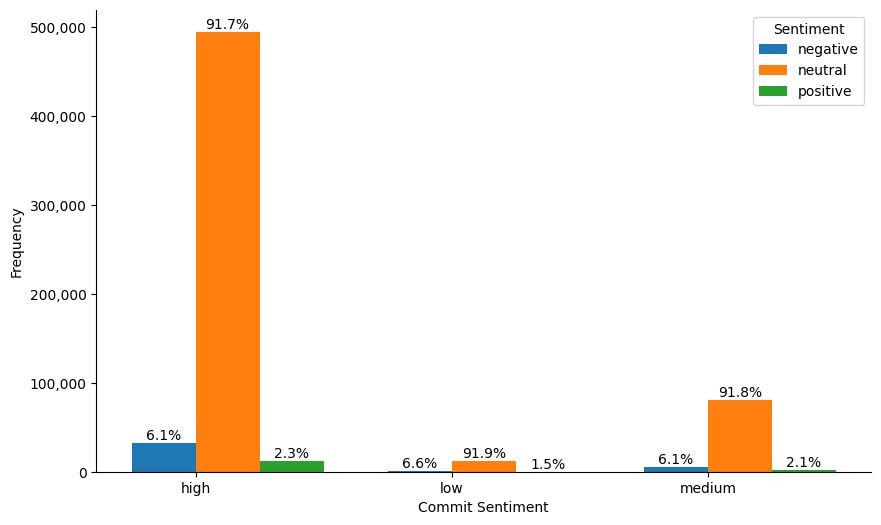

In [4]:
grouped = df.groupby(['category', 'message_sentiment']).size().unstack(fill_value=0)
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))  

sentiments = grouped.columns
issue_types = grouped.index

bar_width = 0.25
bar_positions = list(range(len(issue_types)))

for i, sentiment in enumerate(sentiments):
    offset = i * bar_width - bar_width / 2

    bars = plt.bar([pos + offset for pos in bar_positions], grouped[sentiment], width=bar_width, label=sentiment)
    
    for bar, pct in zip(bars, grouped_percent[sentiment]):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)


# Customize plot
plt.xlabel('Commit Sentiment')
plt.ylabel('Frequency')
# plt.title('Sentiment Frequencies by Issue Type')
plt.xticks(bar_positions, issue_types)
plt.legend(title='Sentiment', loc='upper right')
plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False)  
plt.gca().get_xaxis().tick_bottom() 
plt.gca().get_yaxis().tick_left()  
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.grid(False)
plt.show()

In [5]:
rq1 = df.groupby(['category', 'message_sentiment']).size()
rq1 = rq1.unstack().reset_index()
rq1.columns.name=None

In [6]:
rq1

,category,negative,neutral,positive
0,high,32721,495019,12184
1,low,884,12261,196
2,medium,5432,81111,1820


# Chi square test

In [7]:
contingency_table = rq1.set_index('category')[['negative', 'positive', 'neutral']].T
print("Contingency Table:")
print(contingency_table)

# Perform the Chi-square test
chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-squared statistic: {chi2}\np-value: {p_chi2}\nDegree of Freedom (dof): {dof}")

# Create a rq1Frame for the expected frequencies
expected_df = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
print("\nExpected Frequency Table:")
print(expected_df)

# Interpret the Chi-square test results
if p_chi2 < 0.05:
    print('\nChi-squared test: There is a statistically significant association between commit frequency and the sentiment counts (negative, positive, neutral).')
else:
    print('\nChi-squared test: There is no significant association between commit frequency and the sentiment counts (negative, positive, neutral).')

Contingency Table:
category    high    low  medium
negative   32721    884    5432
positive   12184    196    1820
neutral   495019  12261   81111

Chi-squared statistic: 55.067899563179445
p-value: 3.14426714294055e-11
Degree of Freedom (dof): 4

Expected Frequency Table:
category           high           low        medium
negative   32849.272769    811.673769   5376.053462
positive   11949.168054    295.252389   1955.579557
neutral   495125.559178  12234.073842  81031.366981

Chi-squared test: There is a statistically significant association between commit frequency and the sentiment counts (negative, positive, neutral).


# Z test

Low committer

In [8]:
rq1['total_sentiments'] = rq1['negative'] + rq1['positive'] + rq1['neutral']

# Calculate the negative sentiment percentage
rq1['negative_percentage'] = (rq1['negative'] / rq1['total_sentiments']) * 100

# Extract the negative sentiment counts and total sentiment counts
negatives = rq1['negative'].values
totals = rq1['total_sentiments'].values

# Proportions for low, medium, and high
prop_low = negatives[1] / totals[1]
prop_medium = negatives[2] / totals[2]
prop_high = negatives[0] / totals[0]

# Performing z-test for low vs medium and low vs high
count_low_medium = [negatives[1], negatives[2]]
nobs_low_medium = [totals[1], totals[2]]
z_stat_low_medium, p_value_low_medium = proportions_ztest(count_low_medium, nobs_low_medium)

count_low_high = [negatives[1], negatives[0]]
nobs_low_high = [totals[1], totals[0]]
z_stat_low_high, p_value_low_high = proportions_ztest(count_low_high, nobs_low_high)

# Print the results
print(f"Negative Sentiment Proportions:\nLow: {prop_low * 100:.2f}%\nMedium: {prop_medium * 100:.2f}%\nHigh: {prop_high * 100:.2f}%")
print(f"\nZ-test Results:")
print(f"Low vs Medium: Z-statistic = {z_stat_low_medium:.4f}, P-value = {p_value_low_medium:.4f}")
print(f"Low vs High: Z-statistic = {z_stat_low_high:.4f}, P-value = {p_value_low_high:.4f}")

# Interpret the results
if p_value_low_medium < 0.05 and p_value_low_high < 0.05:
    print("\nThe hypothesis that low committer frequency has a significantly different negative sentiment percentage is supported.")
else:
    print("\nThe hypothesis is not supported.")

Negative Sentiment Proportions:
Low: 6.63%
Medium: 6.15%
High: 6.06%

Z-test Results:
Low vs Medium: Z-statistic = 2.1360, P-value = 0.0327
Low vs High: Z-statistic = 2.7033, P-value = 0.0069

The hypothesis that low committer frequency has a significantly different negative sentiment percentage is supported.
